In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
@numba.njit
def Gillespie_reg(r_0=0, p_0=0, Kr=1, Kp=50, Gr=1/5, Gp=1/30, dt_reg=0.1, t_max=200, seed=0):
    """
    Runs a regularized simulation for constant transcription, traduction and degradetion (of both mRNA and protein) using the Gillespie algorithm.
    
    Parameters
    ----------
    r_0 : int, optional
        Initial number of mRNAs.-
    p_0 : int, optional
        Initial number of proteins.
    Kr : float, optional
        Rate of mRNA creation (transcription).
    Kp : float, optional
        Rate of protein creation (traduction).
    Gr : float, optional
        Rate of mRNA degradation.
    Gp : float, optional
        Rate of protein degradation.
    dt_reg : float, optional
        Regularized time interval.
    t_max : int, optional
        Maximum celular time.
    seed: int, optional
        Random number generator seed.
    
    Returns
    -------
    dict
    Contains the vectors for the number of mRNAs, proteins and regular interval times.
    """
    r = r_0
    p = p_0
    t = 0
    t_size = round(t_max/dt_reg)
    R = np.zeros(t_size)
    R[0] = r
    P = np.zeros(t_size)
    P[0] = p
    T = np.zeros(t_size)
    
    np.random.seed(seed)
    i = 1
    while i < t_size:     
        t_i = i*dt_reg
        while t < t_i:
            S1 = Kr
            S2 = Gr*r
            S3 = Kp*r
            S4 = Gp*p
            Stot = S1 + S2 + S3 + S4
            U = np.random.rand()
            t+=np.random.exponential(scale=1/Stot)
            if (U < S1/Stot):
                r+=1
            elif (U < (S1+S2)/Stot):
                r-=1
            elif (U < (S1+S2+S3)/Stot):
                p+=1
            else:
                p-=1    
        R[i]=r
        P[i]=p
        T[i]=t_i
        i+=1
    return {'t':T, 'r':R, 'p':P}

@numba.njit
def Gillespie_pop(n_cells=100, r_0=0, p_0=0, Kr=1, Kp=50, Gr=1/5, Gp=1/30, dt_reg=0.1, t_max=200):
    """
    Runs a regularized simulation for constant transcription, traduction and degradetion (of both mRNA and protein) using the 
    Gillespie algorithm for a population of cells.
    
    Parameters
    ----------
    n_cells : int, optional
        Cell population size.
    r_0 : int, optional
        Initial number of mRNAs.
    p_0 : int, optional
        Initial number of proteins.
    Kr : float, optional
        Rate of mRNA creation (transcription).
    Kp : float, optional
        Rate of protein creation (traduction).
    Gr : float, optional
        Rate of mRNA degradation.
    Gp : float, optional
        Rate of protein degradation.
        dt : float, optional
        Time step.
    dt_reg : float, optional
        Regularized time interval.
    t_max : int, optional
        Maximum celular time.
    seed: int, optional
        Random number generator seed.
    
    Returns
    -------
    dict
    Contains a dictionary for each simulated cell, with its corresponding vectors for the number of mRNAs, proteins and regular 
    interval times.
    """
    pop = {}
    for j in range(n_cells):
        pop[j] = Gillespie_reg(r_0, p_0, Kr, Kp, Gr, Gp, dt_reg, t_max, seed=j)
    return pop

def Regularized_pop_stats(cells, n_cells=100, dt_reg=0.1, t_max=200, ss=-1):
    """
    Returns relevant information about the simulation of the cell population .
    
    Parameters
    ----------
    cells : dict
        Information of the simulation of a population of cells.
    n_cells : int, optional
        Cell population size.
    dt : float, optional
        Regularized time interval.
    t_max : int, optional
        Maximum celular time.
    ss: int, optional
        position of the vector at which steady state is reached.
    
    Returns
    -------
    dict
    Contains the vectors for: the cellular time, average number of mRNAS, average number of proteins, number of mRNAS at the steady 
    state for each cell, number of proteins at the steady state for each cell.
    Contains the values for the mean and the noise of the number of mRNAS and proteins at the steady state.
    """
    t_size = round(t_max/dt_reg)
    
    t = cells[0]['t']
    r_mean = np.zeros(t_size)
    r_std = np.zeros(t_size)
    p_mean = np.zeros(t_size)
    p_std = np.zeros(t_size)
    for i in range(t_size):
        cell_r = np.zeros(n_cells)
        cell_p = np.zeros(n_cells)
        for j in cells:
            cell_r[j] = cells[j]['r'][i]
            cell_p[j] = cells[j]['p'][i]
        r_mean[i] = cell_r.mean()
        r_std[i] = cell_r.std()
        p_mean[i] = cell_p.mean()
        p_std[i] = cell_p.std()
    
    r_ss = np.zeros(n_cells)
    p_ss = np.zeros(n_cells)
    for j in cells:
        r_ss[j] = cells[j]['r'][ss]
        p_ss[j] = cells[j]['p'][ss]
    r_ss_mean = r_ss.mean()
    r_ss_noise = r_ss.std()/r_ss_mean
    p_ss_mean = p_ss.mean()
    p_ss_noise = p_ss.std()/p_ss_mean
    
    return {'t':t, 
            'r_mean':r_mean, 'r_std':r_std, 
            'p_mean':p_mean, 'p_std':p_std, 
            'r_ss':r_ss, 'p_ss':p_ss, 
            'r_ss_mean':r_ss_mean, 'r_ss_noise':r_ss_noise, 
            'p_ss_mean':p_ss_mean, 'p_ss_noise':p_ss_noise}

In [3]:
cells = Gillespie_pop()
cells_stats = Regularized_pop_stats(cells)

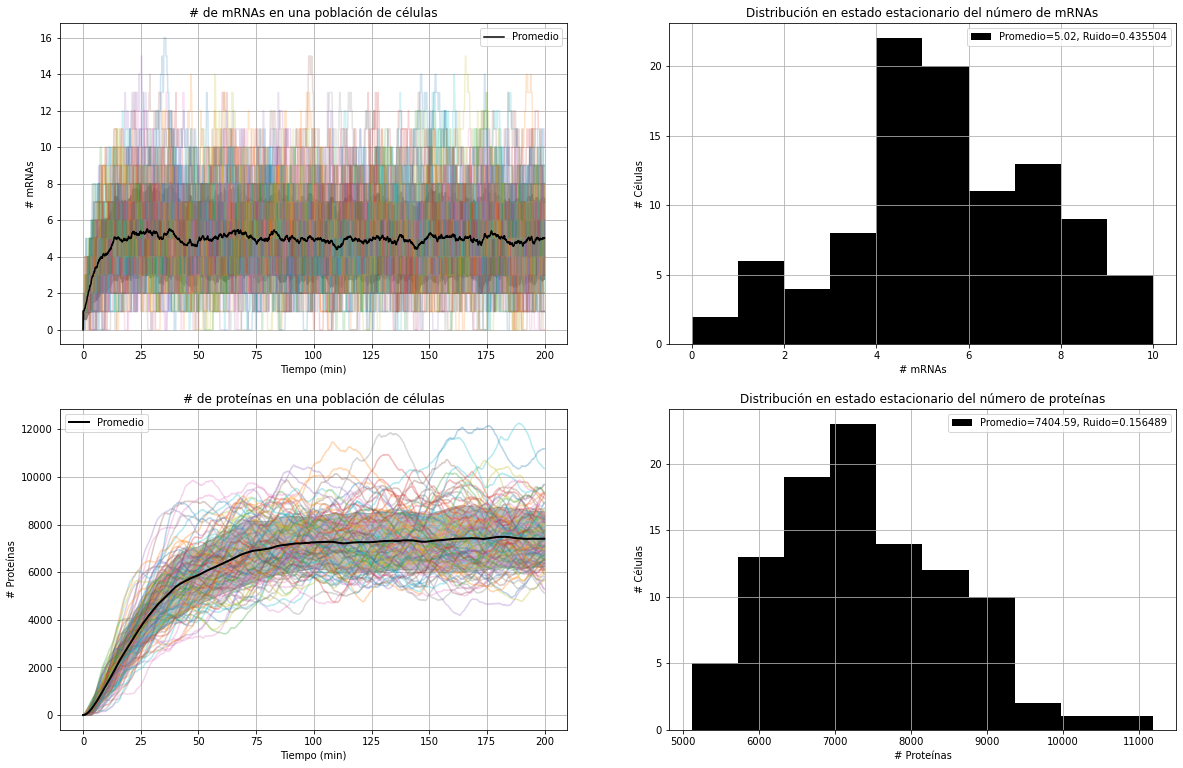

In [4]:
plt.figure(figsize=(20,13))
plt.subplot(2,2,1)
for j in range(len(cells)):
    plt.plot(cells[j]['t'], cells[j]['r'], alpha=0.2)
plt.plot(cells_stats['t'], cells_stats['r_mean'], c='k', label='Promedio')
plt.fill_between(cells_stats['t'], cells_stats['r_mean']-cells_stats['r_std'], cells_stats['r_mean']+cells_stats['r_std'], color='gray', alpha=0.9)
plt.legend(loc=0)
plt.xlabel('Tiempo (min)')
plt.ylabel('# mRNAs')
plt.title('# de mRNAs en una población de células')
plt.grid()
plt.subplot(2,2,2)
plt.hist(cells_stats['r_ss'], color='k', label='Promedio={}, Ruido={:2f}'.format(cells_stats['r_ss_mean'], cells_stats['r_ss_noise']))
plt.legend(loc=0)
plt.xlabel('# mRNAs')
plt.ylabel('# Células')
plt.title('Distribución en estado estacionario del número de mRNAs')
plt.grid()
plt.subplot(2,2,3)
for j in range(len(cells)):
    plt.plot(cells[j]['t'], cells[j]['p'], alpha=0.3)
plt.plot(cells_stats['t'], cells_stats['p_mean'], c='k', label='Promedio', linewidth=2)
plt.fill_between(cells_stats['t'], cells_stats['p_mean']-cells_stats['p_std'], cells_stats['p_mean']+cells_stats['p_std'], color='gray', alpha=0.5)
plt.legend(loc=0)
plt.xlabel('Tiempo (min)')
plt.ylabel('# Proteínas')
plt.title('# de proteínas en una población de células')
plt.grid()
plt.subplot(2,2,4)
plt.hist(cells_stats['p_ss'], color='k', label='Promedio={}, Ruido={:2f}'.format(cells_stats['p_ss_mean'], cells_stats['p_ss_noise']))
plt.legend(loc=0)
plt.xlabel('# Proteínas')
plt.ylabel('# Células')
plt.title('Distribución en estado estacionario del número de proteínas')
plt.grid()
plt.show()